In [43]:
LOCAL = True

In [44]:
if LOCAL:
    !pip install segmentation_models_pytorch
    !pip install timm
else:
    !pip install ../input/segmentation-models-pytorch-021/wheels/pretrainedmodels-0.7.4-py3-none-any.whl
    !pip install ../input/segmentation-models-pytorch-021/wheels/timm-0.4.12-py3-none-any.whl
    !pip install ../input/segmentation-models-pytorch-021/wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
    !pip install ../input/segmentation-models-pytorch-021/wheels/segmentation_models_pytorch-0.2.1-py3-none-any.whl

In [45]:
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import pandas as pd
import os
import tifffile
from tifffile import TiffFile
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
import rasterio
from rasterio.windows import Window
import torch.nn.functional as F
import math
import warnings; warnings.filterwarnings("ignore")

# Config

In [46]:
class config:
    BATCH_SIZE = 1
    TRAIN_SIZE = 256
    TRAIN_PIXEL_SIZE = 0.4
    VALID = True
    FOLDS = [0]
    organ_type = {'lung':1, 'kidney':2, 'largeintestine':3, 'prostate':4, 'spleen':5}
    #TH = {'lung':0.15, 'kidney':0.34, 'largeintestine':0.57, 'prostate':0.3, 'spleen':0.41} #eff b3
    TH = {'lung':0.15, 'kidney':0.4, 'largeintestine':0.4, 'prostate':0.40, 'spleen':0.4}
    
    ARCH = 'unetplusplus'
    BACKBONE = 'efficientnet-b7'
    WEIGHT = '../working/Models/Patch/test/fold_0/02_PostTrain/Models/'
    
    ### TEST ###
    TEST_CSV = '../input/hubmap-organ-segmentation/'
    TEST_DATA = '../input/hubmap-organ-segmentation/test_images/'
    
    ### VALID ###
    VALID_CSV = '../input/hubmap-organ-segmentation/'
    VALID_DATA = '../input/hubmap-organ-segmentation/train_images/'
    NUM_WORKERS = 2

In [47]:
if config.VALID:
    IMG_DATA = '../input/hubmap-organ-segmentation/train_images/'
    CSV_DATA = []
    for fold in [0]:#config.FOLDS:
        CSV_DATA.append(config.VALID_CSV + f'fold_{fold}_valid.csv')
else:
    IMG_DATA = '../input/hubmap-organ-segmentation/test_images/'
    CSV_DATA = [config.TEST_CSV + 'test.csv']

In [48]:
bs = 64
sz = 1024    # the size of tiles
reduce = 4  # reduce the original images by 4 times
TH = 0.225  # threshold for positive predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

## Data

In [49]:
# functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    #for m,enc in enumerate(encs):
    #if isinstance(enc,np.float) and np.isnan(enc): continue
    s = encs.split()
    for i in range(len(s)//2):
        start = int(s[2*i]) - 1
        length = int(s[2*i+1])
        img[start:start+length] = 1
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [50]:
# https://www.kaggle.com/datasets/thedevastator/hubmap-2022-256x256
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

s_th = 40  #saturation blancking threshold
p_th = 1000*(sz//256)**2 #threshold for the minimum number of pixels
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, idx, sz=sz, reduce=reduce, pixel_size = 0.4):
        
        with TiffFile(os.path.join(IMG_DATA,idx+'.tiff')) as tif:
            data = tif.asarray()
        
        scale = pixel_size / 0.4
        w = int(data.shape[1] * scale)
        h = int(data.shape[0] * scale)
        data = cv2.resize(data, (w, h), interpolation = cv2.INTER_AREA)
        tifffile.imsave(idx+'.tiff', data)
        self.data = rasterio.open(idx+'.tiff', transform = identity,
                            num_threads='all_cpus')
        """

        self.data = rasterio.open(os.path.join(IMG_DATA,idx+'.tiff'), transform = identity,
                            num_threads='all_cpus')
        """
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape

        self.reduce = reduce
        self.sz = reduce*sz
        
        self.hsz = self.sz // 2
        self.n0max = math.ceil(self.shape[0] / self.hsz) + 1
        self.n1max = math.ceil(self.shape[1] / self.hsz) + 1
        """
        self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz
        self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        self.n0max = (self.shape[0] + self.pad0)//self.sz
        self.n1max = (self.shape[1] + self.pad1)//self.sz
        """
        # 4 256 1024 2023 2023 25 25 2 2
        # print(self.reduce, sz, self.sz, self.shape[0], self.shape[1], self.pad0, self.pad1, self.n0max, self.n1max)

        os.remove(idx+'.tiff')
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        # the code below may be a little bit difficult to understand,
        # but the thing it does is mapping the original image to
        # tiles created with adding padding, as done in
        # https://www.kaggle.com/iafoss/256x256-images ,
        # and then the tiles are loaded with rasterio
        # n0,n1 - are the x and y index of the tile (idx = n0*self.n1max + n1)
        n0,n1 = idx//self.n1max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        
        #x0,y0 = -self.pad0//2 + n0*self.sz, -self.pad1//2 + n1*self.sz
        x0,y0 = -self.hsz + n0*self.hsz, -self.hsz + n1*self.hsz
        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])

        
        

        img = np.zeros((self.sz,self.sz,3),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
        
        return img2tensor((img/255.0 - mean)/std), idx

In [51]:
#iterator like wrapper that returns predicted masks
class Model_pred:
    def __init__(self, models, dl, tta:bool=True, half:bool=False):
        self.models = models
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                if ((y>=0).sum() > 0): #exclude empty images
                    x = x[y>=0].to(device)
                    y = y[y>=0]
                    if self.half: x = x.half()
                    py = None
                    for model in self.models:
                        p = model(x)
                        p = torch.sigmoid(p).detach()
                        tmp = p
                        #if py is None: py = p
                        #else: py += p
                        #else: py = torch.fmax(py, p)
                        if self.tta:
                            #x,y,xy flips as TTA
                            flips = [[-1],[-2],[-2,-1]]
                            for f in flips:
                                xf = torch.flip(x,f)
                                p = model(xf)
                                p = torch.flip(p,f)
                                #py += torch.sigmoid(p).detach()
                                #py = torch.fmax(torch.sigmoid(p).detach(), p)
                                tmp += torch.sigmoid(p).detach()
                        #py /= (1+len(flips))        
                        tmp /= (1+len(flips))
                        if py is None: py = tmp.cpu().numpy()
                        else: py = np.fmax(py, tmp.cpu().numpy())
                    #py /= len(self.models)

                    py = F.upsample(torch.from_numpy(py), scale_factor=reduce, mode="bilinear")
                    py = py.permute(0,2,3,1).float().cpu()
                    
                    batch_size = len(py)
                    for i in range(batch_size):
                        yield py[i],y[i]
                        count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)

# Metric

In [52]:
def compute_dice_score(probability, mask, organ):
    N = len(probability.flatten())
    p = probability.reshape(N)
    t = mask.reshape(N)

    p = p>config.TH[organ]
    t = t>0.00
    uion = p.sum(-1) + t.sum(-1)
    overlap = (p*t).sum(-1)
    dice = 2*overlap/(uion+0.0001)
    return dice

# dice with automatic threshold selection
class Dice_th():
    def __init__(self, ths=np.arange(0.0,1.0,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, prob, mask):
        N = len(prob)
        pred = prob.reshape(N,-1)
        targ = mask.reshape(N,-1)
        
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

class Dice_th_pred():
    def __init__(self, ths=np.arange(0.0,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, prob, mask):
        N = len(prob)
        pred = prob.reshape(N,-1)
        targ = mask.reshape(N,-1)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices

## Model

In [53]:
def getModels():
    MODELS = []
    for fold in config.FOLDS:
        model = smp.create_model(arch=config.ARCH, encoder_weights=None, encoder_name=config.BACKBONE, classes=1, activation=None)
        #model_name = config.WEIGHT + f'model_fold{fold}_{config.BACKBONE}_78.pth'
        model_name = f'/kaggle/working/model_fold{fold}_efficientnet-b7_score_dice.pth'
        state_dict = torch.load(model_name,map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        model.float()
        model.eval()
        model.cuda()
        MODELS.append(model)
        
    return MODELS

def getValidData(fold=0):
    ds_v = HuBMAPDataset(fold=fold, train=False)
    v_dataloader = DataLoader(dataset=ds_v, batch_size=config.bs, shuffle=False, num_workers=config.NUM_WORKERS)
    
    return v_dataloader

## Prediction

In [54]:
def margeMask(ds, mask):

    mmask = torch.zeros(ds.hsz * (ds.n0max + 1),ds.hsz * (ds.n1max + 1),dtype=torch.float32)
    for h in range(ds.n0max):
        for w in range(ds.n1max):
            sy = h*ds.hsz
            sx = w*ds.hsz
            mmask[sy:sy+ds.sz, sx:sx+ds.sz] += mask[h, w, :,:]

    return mmask[ds.hsz:ds.hsz+ds.shape[0],ds.hsz:ds.hsz+ds.shape[1]] / 4.0

100%|██████████| 60/60 [15:46<00:00, 15.78s/it]


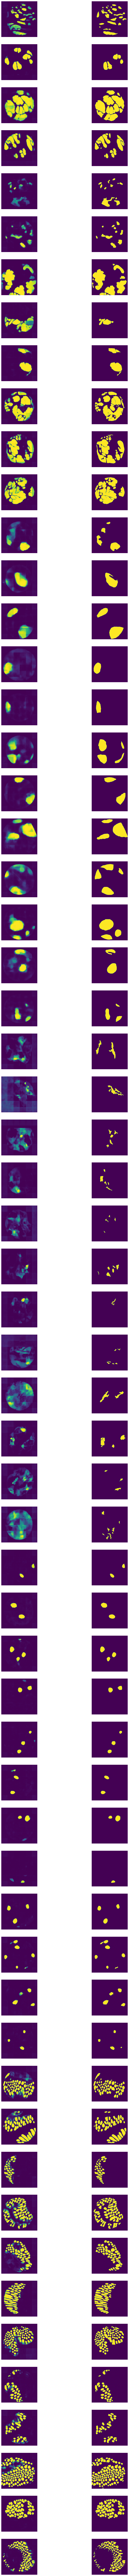

In [55]:
models = getModels()
names,preds = [],[]
plt.figure(figsize=(16, 256))

if config.VALID:
    scores = {}
    metric = Dice_th_pred()
    metric.reset()

    organ_score = {}
    for key in config.organ_type:
        organ_score[key] = Dice_th_pred()
        organ_score[key].reset()

res_pattern = [256, 512, 768]

for csv in CSV_DATA:
    df = pd.read_csv(csv)
    for VID, (idx,row) in enumerate(tqdm(df.iterrows(),total=len(df))):
        idx = str(row['id'])
        pixel_size = float(row['pixel_size'])
        mask = None
        for res in res_pattern:
            ds = HuBMAPDataset(idx, sz = res, pixel_size=pixel_size)
            #rasterio cannot be used with multiple workers
            dl = DataLoader(ds,bs,num_workers=0,shuffle=False,pin_memory=True)
            mp = Model_pred(models,dl)
            #generate masks
            _mask = torch.zeros(len(ds),ds.sz,ds.sz,dtype=torch.float32)
            #for p,i in iter(mp): mask[i.item()] = p.squeeze(-1) > TH
            for p,i in iter(mp): _mask[i.item()] = p.squeeze(-1)
            
            #reshape tiled masks into a single mask and crop padding
            """
            _mask = _mask.view(ds.n0max,ds.n1max,ds.sz,ds.sz).\
                permute(0,2,1,3).reshape(ds.n0max*ds.sz,ds.n1max*ds.sz)
            _mask = _mask[ds.pad0//2:-(ds.pad0-ds.pad0//2) if ds.pad0 > 0 else ds.n0max*ds.sz,
                ds.pad1//2:-(ds.pad1-ds.pad1//2) if ds.pad1 > 0 else ds.n1max*ds.sz]

            """
            _mask = _mask.view(ds.n0max,ds.n1max,ds.sz,ds.sz)
            _mask = margeMask(ds, _mask)            
            _mask = torch.reshape(_mask, (1,1, _mask.shape[1], _mask.shape[0]))
            _mask = F.interpolate(_mask, (row['img_height'],row['img_width']), mode='bilinear', align_corners=False)
            
            if mask == None:
                mask = _mask
            else:
                mask += _mask

        mask /= len(res_pattern)

        #convert to rle
        #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
        rle = rle_encode_less_memory((mask > config.TH[row['organ']]).to(torch.uint8).numpy())
        names.append(idx)
        preds.append(rle)
        
        if config.VALID:
            label = img2tensor(enc2mask(row['rle'], (row['img_width'], row['img_height'])))
            score = compute_dice_score(mask, label, row['organ'])
            tmp = scores.get(row['organ'], [])
            tmp.append(score.item())
            scores[row['organ']] = tmp
            metric.accumulate(mask, label)
            organ_score[row['organ']].accumulate(mask, label)

            #mask = torch.reshape(mask, (1, 1, mask.shape[1], mask.shape[0]))
            mask = F.interpolate(mask, (256, 256), mode='bilinear', align_corners=False)
            label = torch.reshape(label, (1,1, label.shape[1], label.shape[2]))
            label = F.interpolate(label, (256, 256), mode='bilinear', align_corners=False)

            label = label.to('cpu').detach().numpy().copy().reshape(256, 256, 1)
            mask = mask.to('cpu').detach().numpy().copy().reshape(256, 256, 1)
            plt.subplot(60, 2, VID * 2 + 1)
            plt.imshow(mask)#, cmap="jet", alpha=0.5)
            plt.axis("off")
            plt.subplot(60, 2, VID * 2 + 2)
            plt.imshow(label)#, cmap="jet", alpha=0.5)
            plt.axis("off")
        
        del mask, ds, dl
        gc.collect()

In [56]:
df = pd.DataFrame({'id':names,'rle':preds})
df.to_csv('submission.csv',index=False)

In [57]:
df.head()

,id,rle
0,20428,1561913 10 1564910 16 1567908 20 1570907 22 15...
1,29213,841311 26 844306 41 847302 59 850298 132 85329...
2,4658,871567 20 874562 47 877559 60 880555 73 883552...
3,21086,727347 10 730339 31 733334 49 736331 60 739327...
4,26982,1692893 15 1695889 23 1698887 27 1701884 32 17...


In [58]:
total_score = []
for key in scores:
    print(key , f': {np.average(scores[key])}')
    total_score.extend(scores[key])
print(f'total : {np.average(total_score)}')

prostate : 0.8248146971066793
spleen : 0.8440977036952972
lung : 0.24132438252369562
kidney : 0.9498521089553833
largeintestine : 0.9158945381641388
total : 0.7551966860890389


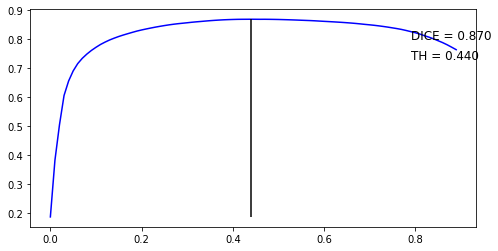

In [59]:
dices = metric.value
noise_ths = metric.ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()


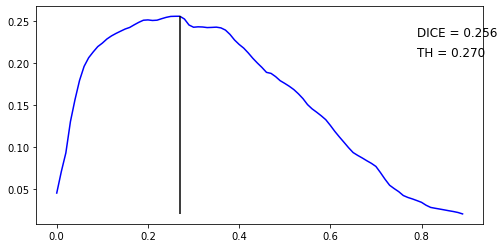

In [60]:
dices = organ_score['lung'].value
noise_ths = organ_score['lung'].ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

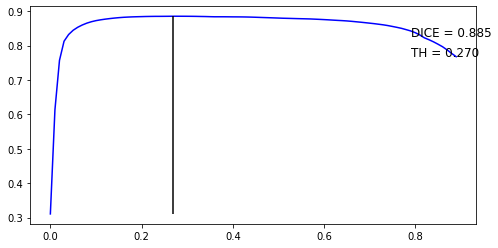

In [61]:
dices = organ_score['prostate'].value
noise_ths = organ_score['prostate'].ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

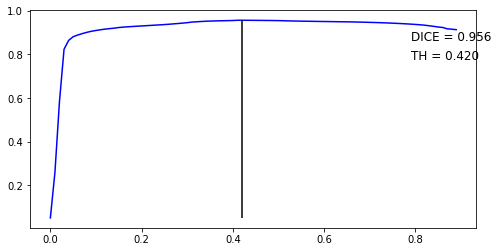

In [62]:
dices = organ_score['kidney'].value
noise_ths = organ_score['kidney'].ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

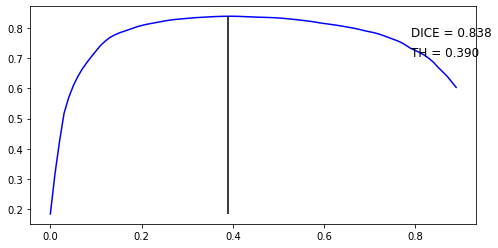

In [63]:
dices = organ_score['spleen'].value
noise_ths = organ_score['spleen'].ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

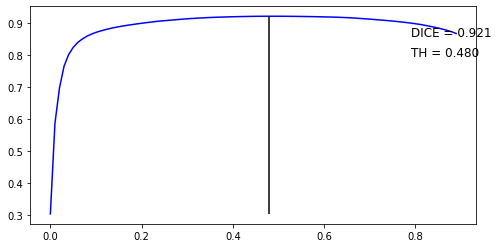

In [64]:
dices = organ_score['largeintestine'].value
noise_ths = organ_score['largeintestine'].ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

In [65]:
import numpy as np

a = np.array([0,1,2,3,4,5,6,7,8,9])
b = np.array([9,8,7,6,5,4,3,2,1,0])

np.fmax(a,b)

array([9, 8, 7, 6, 5, 5, 6, 7, 8, 9])